In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, MultiPoint
from shapely.ops import unary_union
import pandas as pd
from typing import List, Tuple, Optional

class PlotSimulation:
    def __init__(self, width: float = 10.0, height: float = 10.0, n_plants: int = 20,
                 distribution: str = 'random', distribution_params: dict = None,
                 detection_params: dict = None):
        """
        Initialize a plot simulation with customizable plant distribution and detection parameters.
        
        Args:
            width: Plot width in meters
            height: Plot height in meters
            n_plants: Number of plants
            distribution: Type of distribution ('random', 'clustered', 'regular', 'gradient')
            distribution_params: Parameters for the chosen distribution
                - clustered: {'n_clusters': int, 'cluster_std': float}
                - regular: {'jitter': float}
                - gradient: {'direction': str, 'steepness': float}
            detection_params: Parameters for detection radius
                - Can be either a fixed radius (float) or a dict with:
                    {'distribution': 'uniform'/'normal'/'lognormal',
                     'params': {'min': float, 'max': float} or 
                              {'mean': float, 'std': float}}
        """
        self.width = width
        self.height = height
        self.n_plants = n_plants
        
        # Set default distribution parameters if none provided
        self.distribution = distribution
        self.distribution_params = distribution_params or {}
        
        # Set default detection parameters if none provided
        if detection_params is None:
            self.detection_params = {'fixed': 0.2}
        elif isinstance(detection_params, (int, float)):
            self.detection_params = {'fixed': float(detection_params)}
        else:
            self.detection_params = detection_params
            
        # Generate plants and their detection buffers
        self.plants = self._generate_plants()
        self.plant_buffers = self._create_plant_buffers()
        
    def _generate_plants(self) -> List[Point]:
        """Generate plant locations based on specified distribution."""
        if self.distribution == 'random':
            return self._generate_random_plants()
        elif self.distribution == 'clustered':
            return self._generate_clustered_plants()
        elif self.distribution == 'regular':
            return self._generate_regular_plants()
        elif self.distribution == 'gradient':
            return self._generate_gradient_plants()
        else:
            raise ValueError(f"Unknown distribution type: {self.distribution}")
    
    def _generate_random_plants(self) -> List[Point]:
        """Generate completely random plant locations."""
        x_coords = np.random.uniform(0, self.width, self.n_plants)
        y_coords = np.random.uniform(0, self.height, self.n_plants)
        return [Point(x, y) for x, y in zip(x_coords, y_coords)]
    
    def _generate_clustered_plants(self) -> List[Point]:
        """Generate clustered plant distribution using Gaussian clusters."""
        n_clusters = self.distribution_params.get('n_clusters', 3)
        cluster_std = self.distribution_params.get('cluster_std', 1.0)
        
        # Generate cluster centers
        cluster_centers_x = np.random.uniform(cluster_std, self.width - cluster_std, n_clusters)
        cluster_centers_y = np.random.uniform(cluster_std, self.height - cluster_std, n_clusters)
        
        points = []
        plants_per_cluster = self.n_plants // n_clusters
        remaining_plants = self.n_plants % n_clusters
        
        for i in range(n_clusters):
            n_plants_this_cluster = plants_per_cluster + (1 if i < remaining_plants else 0)
            
            # Generate points around cluster center
            x_coords = np.random.normal(cluster_centers_x[i], cluster_std, n_plants_this_cluster)
            y_coords = np.random.normal(cluster_centers_y[i], cluster_std, n_plants_this_cluster)
            
            # Clip to plot boundaries
            x_coords = np.clip(x_coords, 0, self.width)
            y_coords = np.clip(y_coords, 0, self.height)
            
            points.extend([Point(x, y) for x, y in zip(x_coords, y_coords)])
            
        return points
    
    def _generate_regular_plants(self) -> List[Point]:
        """Generate regularly spaced plants with optional jitter."""
        jitter = self.distribution_params.get('jitter', 0.2)
        
        # Calculate grid spacing
        n_rows = int(np.sqrt(self.n_plants * self.height / self.width))
        n_cols = int(np.sqrt(self.n_plants * self.width / self.height))
        
        row_spacing = self.height / (n_rows + 1)
        col_spacing = self.width / (n_cols + 1)
        
        points = []
        for i in range(1, n_rows + 1):
            for j in range(1, n_cols + 1):
                if len(points) < self.n_plants:
                    # Add jitter to regular positions
                    x = j * col_spacing + np.random.uniform(-jitter, jitter)
                    y = i * row_spacing + np.random.uniform(-jitter, jitter)
                    
                    # Clip to plot boundaries
                    x = np.clip(x, 0, self.width)
                    y = np.clip(y, 0, self.height)
                    
                    points.append(Point(x, y))
                    
        return points
    
    def _generate_gradient_plants(self) -> List[Point]:
        """Generate plants with density following a gradient."""
        direction = self.distribution_params.get('direction', 'x')
        steepness = self.distribution_params.get('steepness', 1.0)
        
        points = []
        while len(points) < self.n_plants:
            x = np.random.uniform(0, self.width)
            y = np.random.uniform(0, self.height)
            
            # Calculate probability based on position
            if direction == 'x':
                prob = np.exp(-steepness * x / self.width)
            elif direction == 'y':
                prob = np.exp(-steepness * y / self.height)
            else:
                prob = np.exp(-steepness * (x + y) / (self.width + self.height))
                
            if np.random.random() < prob:
                points.append(Point(x, y))
                
        return points
    
    def _create_plant_buffers(self):
        """Create detection buffers around plants with variable radii."""
        if 'fixed' in self.detection_params:
            radius = self.detection_params['fixed']
            return [plant.buffer(radius) for plant in self.plants]
            
        dist_type = self.detection_params.get('distribution', 'uniform')
        params = self.detection_params.get('params', {})
        
        if dist_type == 'uniform':
            min_r = params.get('min', 0.1)
            max_r = params.get('max', 0.3)
            radii = np.random.uniform(min_r, max_r, self.n_plants)
        elif dist_type == 'normal':
            mean = params.get('mean', 0.2)
            std = params.get('std', 0.05)
            radii = np.clip(np.random.normal(mean, std, self.n_plants), 0.01, None)
        elif dist_type == 'lognormal':
            mean = params.get('mean', -2)  # log space
            std = params.get('std', 0.5)   # log space
            radii = np.exp(np.random.normal(mean, std, self.n_plants))
        else:
            raise ValueError(f"Unknown detection radius distribution: {dist_type}")
            
        return [plant.buffer(radius) for plant, radius in zip(self.plants, radii)]
    
    def zigzag_path(self, angle_degrees: float = 0, spacing: float = 2.0) -> LineString:
        """
        Generate a zig-zag search path rotated by a specified angle.
        
        Args:
            angle_degrees: Angle to rotate the entire pattern (default: 0)
            spacing: Distance between parallel segments of the zigzag (default: 2.0m)
        """
        # Convert angle to radians
        angle = np.radians(angle_degrees)
        
        # Calculate number of traverses based on spacing
        n_traverses = max(2, int(np.ceil(self.height / spacing)) + 1)
        points = []
        
        for i in range(n_traverses):
            y = i * spacing
            if i % 2 == 0:
                points.extend([(0, y), (self.width, y)])
            else:
                points.extend([(self.width, y), (0, y)])
        
        # Rotate points around center of plot
        center_x, center_y = self.width/2, self.height/2
        rotated_points = []
        
        for x, y in points:
            # Translate to origin
            tx = x - center_x
            ty = y - center_y
            
            # Rotate
            rx = tx * np.cos(angle) - ty * np.sin(angle)
            ry = tx * np.sin(angle) + ty * np.cos(angle)
            
            # Translate back
            rotated_points.append((rx + center_x, ry + center_y))
                    
        return LineString(rotated_points)
    
    def parallel_path(self, spacing: float = 2.0) -> LineString:
        """
        Generate parallel line search path.
        
        Args:
            spacing: Distance between parallel lines (default: 2.0m)
        """
        # Calculate number of traverses based on spacing
        n_traverses = max(2, int(np.ceil(self.height / spacing)) + 1)
        points = []
        
        for i in range(n_traverses):
            y = i * spacing
            # Ensure we don't exceed plot height
            if y <= self.height:
                points.extend([(0, y), (self.width, y)])
            
        return LineString(points)
    
    def evaluate_path(self, path: LineString) -> Tuple[int, float, List[Point]]:
        """
        Evaluate a search path.
        
        Returns:
            Tuple containing:
            - Number of plants found
            - Total path length
            - List of found plant locations
        """
        plant_union = unary_union(self.plant_buffers)
        intersection = path.intersection(plant_union)
        
        found_plants = []
        for plant, buffer in zip(self.plants, self.plant_buffers):
            if path.intersects(buffer):
                found_plants.append(plant)
                
        return len(found_plants), path.length, found_plants
    
    def plot_simulation(self, path: Optional[LineString] = None, found_plants: Optional[List[Point]] = None):
        """Visualize the plot, plants, and search path."""
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot plant locations and detection buffers
        for plant, buffer in zip(self.plants, self.plant_buffers):
            ax.plot(plant.x, plant.y, 'g.')
            x, y = buffer.exterior.xy
            ax.plot(x, y, 'g--', alpha=0.3)
            
        # Highlight found plants
        if found_plants:
            for plant in found_plants:
                ax.plot(plant.x, plant.y, 'r*', markersize=10)
        
        # Plot search path
        if path:
            x, y = path.xy
            ax.plot(x, y, 'b-', label='Search Path')
            
        ax.set_xlim(-0.5, self.width + 0.5)
        ax.set_ylim(-0.5, self.height + 0.5)
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set_title(f'Plot Simulation ({self.width}m x {self.height}m)')
        ax.set_xlabel('Width (m)')
        ax.set_ylabel('Height (m)')
        plt.legend()
        plt.show()

def run_simulation_comparison(n_trials: int = 10):
    """Run multiple trials comparing different search patterns."""
    results = []
    
    for trial in range(n_trials):
        sim = PlotSimulation()
        
        # Test zig-zag pattern
        zigzag = sim.zigzag_path()
        n_found_zigzag, length_zigzag, found_zigzag = sim.evaluate_path(zigzag)
        
        # Test parallel pattern
        parallel = sim.parallel_path()
        n_found_parallel, length_parallel, found_parallel = sim.evaluate_path(parallel)
        
        results.append({
            'trial': trial,
            'zigzag_found': n_found_zigzag,
            'zigzag_length': length_zigzag,
            'parallel_found': n_found_parallel,
            'parallel_length': length_parallel
        })
    
    return pd.DataFrame(results)

In [2]:
class SearchOptimization:
    def __init__(self, plot_params: dict):
        """
        Initialize search pattern optimization.
        
        Args:
            plot_params: Dictionary containing plot simulation parameters
        """
        self.plot_params = plot_params
        self.results = []
        
    def run_parameter_sweep(self, 
                          n_trials: int = 5,
                          spacings: List[float] = [0.5, 1.0, 1.5, 2.0, 2.5],
                          angles: List[float] = [0, 15, 30, 45, 60]):
        """
        Run systematic tests of different search parameters.
        
        Args:
            n_trials: Number of trials for each parameter combination
            spacings: List of spacing values to test
            angles: List of angles to test (for zigzag only)
        """
        for trial in range(n_trials):
            sim = PlotSimulation(**self.plot_params)
            n_total_plants = sim.n_plants
            
            # Test parallel paths
            for spacing in spacings:
                path = sim.parallel_path(spacing=spacing)
                n_found, path_length, _ = sim.evaluate_path(path)
                
                self.results.append({
                    'trial': trial,
                    'pattern': 'parallel',
                    'spacing': spacing,
                    'angle': None,
                    'n_found': n_found,
                    'n_total': n_total_plants,
                    'detection_rate': n_found / n_total_plants,
                    'path_length': path_length,
                    'efficiency': n_found / path_length if path_length > 0 else 0
                })
            
            # Test zigzag paths
            for spacing in spacings:
                for angle in angles:
                    path = sim.zigzag_path(spacing=spacing, angle_degrees=angle)
                    n_found, path_length, _ = sim.evaluate_path(path)
                    
                    self.results.append({
                        'trial': trial,
                        'pattern': 'zigzag',
                        'spacing': spacing,
                        'angle': angle,
                        'n_found': n_found,
                        'n_total': n_total_plants,
                        'detection_rate': n_found / n_total_plants,
                        'path_length': path_length,
                        'efficiency': n_found / path_length if path_length > 0 else 0
                    })
    
    def analyze_results(self):
        """Analyze and summarize parameter sweep results."""
        df = pd.DataFrame(self.results)
        
        # Group results by pattern and parameters
        parallel_summary = df[df['pattern'] == 'parallel'].groupby('spacing').agg({
            'detection_rate': ['mean', 'std'],
            'path_length': ['mean', 'std'],
            'efficiency': ['mean', 'std']
        })
        
        zigzag_summary = df[df['pattern'] == 'zigzag'].groupby(['spacing', 'angle']).agg({
            'detection_rate': ['mean', 'std'],
            'path_length': ['mean', 'std'],
            'efficiency': ['mean', 'std']
        })
        
        # Find best parameters
        best_parallel = parallel_summary['detection_rate']['mean'].idxmax()
        best_zigzag = zigzag_summary['detection_rate']['mean'].idxmax()
        
        return {
            'parallel_summary': parallel_summary,
            'zigzag_summary': zigzag_summary,
            'best_parallel_spacing': best_parallel,
            'best_zigzag_params': best_zigzag,
            'full_results': df
        }
    
    def plot_best_patterns(self):
        """Plot examples of the best-performing patterns."""
        results = self.analyze_results()
        sim = PlotSimulation(**self.plot_params)
        
        # Plot best parallel pattern
        best_parallel = sim.parallel_path(spacing=results['best_parallel_spacing'])
        n_found, path_length, found_plants = sim.evaluate_path(best_parallel)
        print(f"\nBest Parallel Pattern (spacing={results['best_parallel_spacing']:.1f}m):")
        print(f"Detection Rate: {n_found/sim.n_plants:.2%}")
        print(f"Path Length: {path_length:.1f}m")
        sim.plot_simulation(best_parallel, found_plants)
        
        # Plot best zigzag pattern
        best_spacing, best_angle = results['best_zigzag_params']
        best_zigzag = sim.zigzag_path(spacing=best_spacing, angle_degrees=best_angle)
        n_found, path_length, found_plants = sim.evaluate_path(best_zigzag)
        print(f"\nBest Zigzag Pattern (spacing={best_spacing:.1f}m, angle={best_angle}°):")
        print(f"Detection Rate: {n_found/sim.n_plants:.2%}")
        print(f"Path Length: {path_length:.1f}m")
        sim.plot_simulation(best_zigzag, found_plants)


=== Testing random distribution ===

Parallel pattern summary:
        detection_rate           path_length      efficiency          
                  mean       std        mean  std       mean       std
spacing                                                               
0.5           0.966667  0.040825  410.249844  0.0   0.070689  0.002985
1.0           0.660000  0.123378  210.498756  0.0   0.094062  0.017584
1.5           0.440000  0.072265  130.671245  0.0   0.101017  0.016591
2.0           0.366667  0.150923  110.990195  0.0   0.099108  0.040794
2.5           0.340000  0.072265   91.231056  0.0   0.111804  0.023763

Zigzag pattern summary:
              detection_rate           path_length      efficiency          
                        mean       std        mean  std       mean       std
spacing angle                                                               
0.5     0.0         0.793333  0.072265       220.0  0.0   0.108182  0.009854
        15.0        0.740000  0.079

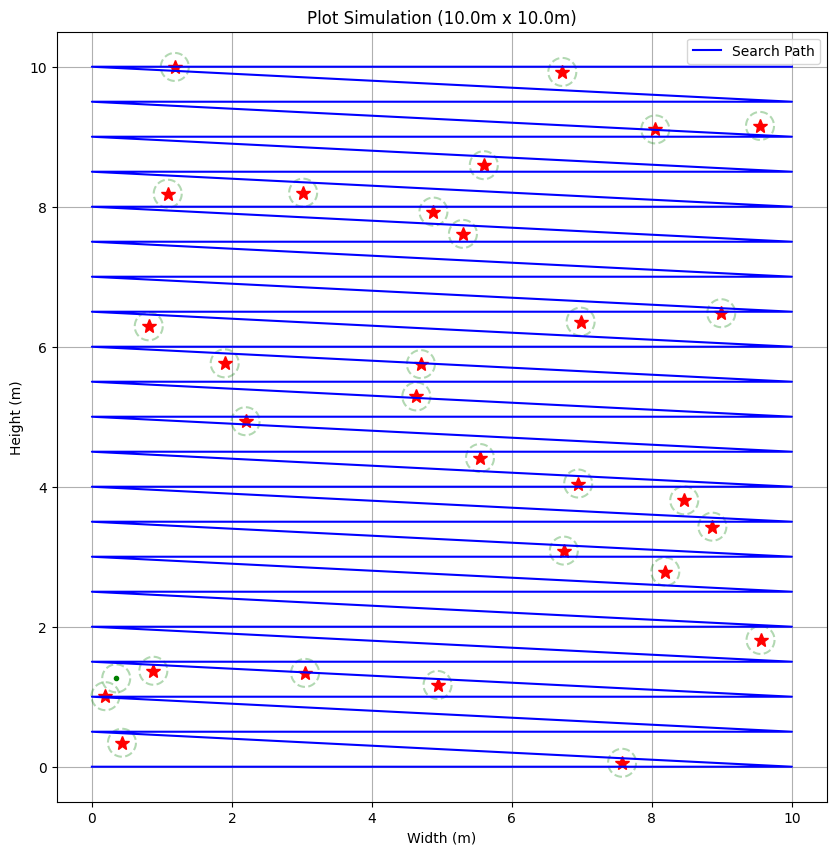


Best Zigzag Pattern (spacing=0.5m, angle=0.0°):
Detection Rate: 76.67%
Path Length: 220.0m


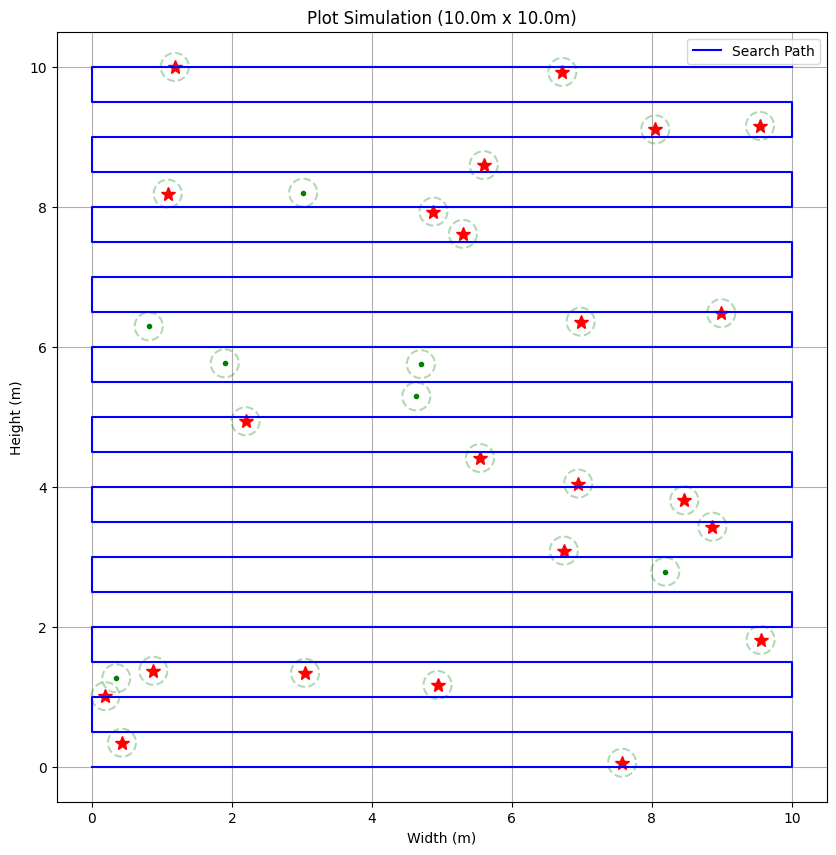


=== Testing clustered distribution ===

Parallel pattern summary:
        detection_rate           path_length      efficiency          
                  mean       std        mean  std       mean       std
spacing                                                               
0.5           0.993333  0.014907  410.249844  0.0   0.072639  0.001090
1.0           0.746667  0.050553  210.498756  0.0   0.106414  0.007205
1.5           0.493333  0.072265  130.671245  0.0   0.113261  0.016591
2.0           0.420000  0.083666  110.990195  0.0   0.113524  0.022614
2.5           0.326667  0.054772   91.231056  0.0   0.107420  0.018011

Zigzag pattern summary:
              detection_rate           path_length      efficiency          
                        mean       std        mean  std       mean       std
spacing angle                                                               
0.5     0.0         0.853333  0.050553       220.0  0.0   0.116364  0.006894
        15.0        0.753333  0.

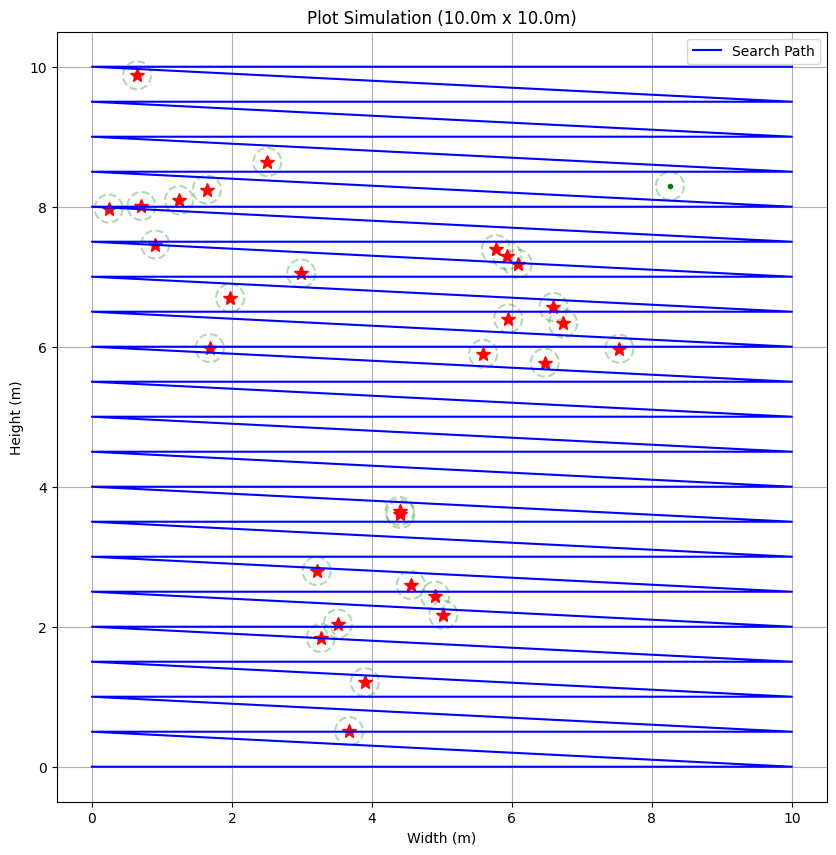


Best Zigzag Pattern (spacing=0.5m, angle=0.0°):
Detection Rate: 83.33%
Path Length: 220.0m


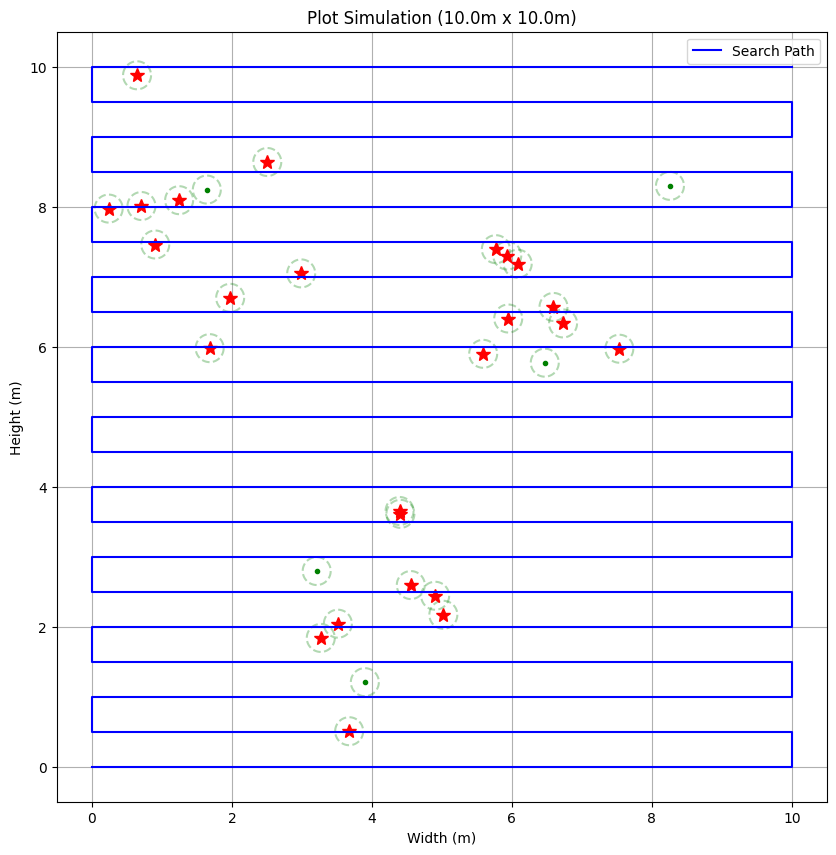


=== Testing regular distribution ===

Parallel pattern summary:
        detection_rate           path_length      efficiency          
                  mean       std        mean  std       mean       std
spacing                                                               
0.5           0.833333  0.000000  410.249844  0.0   0.060938  0.000000
1.0           0.593333  0.082999  210.498756  0.0   0.084561  0.011829
1.5           0.300000  0.057735  130.671245  0.0   0.068875  0.013255
2.0           0.333333  0.062361  110.990195  0.0   0.090098  0.016856
2.5           0.260000  0.086281   91.231056  0.0   0.085497  0.028372

Zigzag pattern summary:
              detection_rate           path_length      efficiency          
                        mean       std        mean  std       mean       std
spacing angle                                                               
0.5     0.0         0.693333  0.068313       220.0  0.0   0.094545  0.009315
        15.0        0.720000  0.08

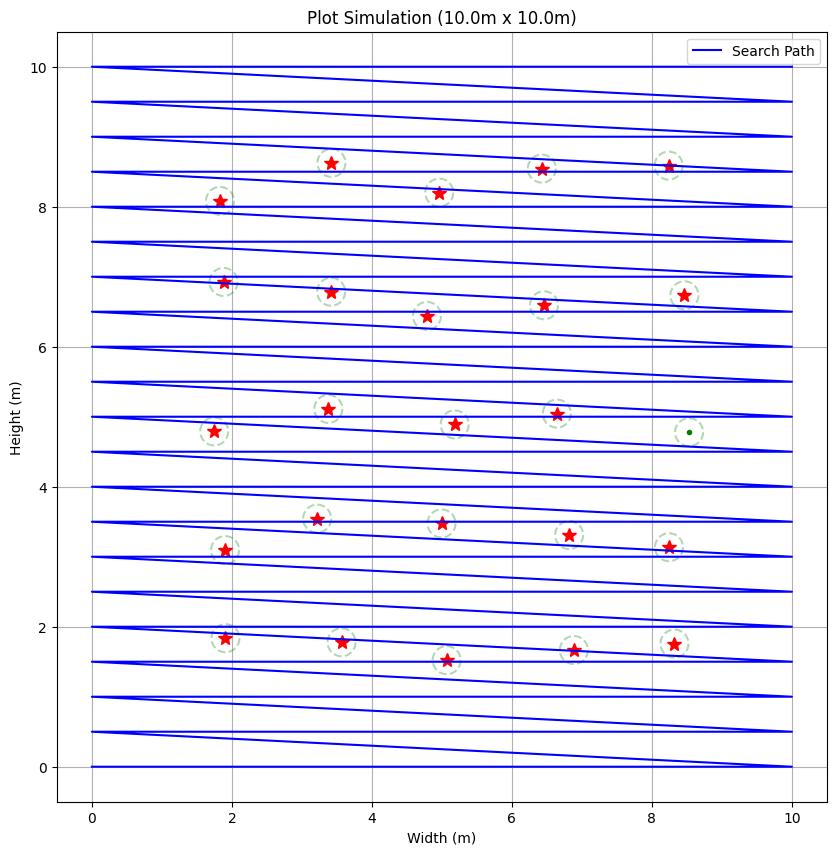


Best Zigzag Pattern (spacing=0.5m, angle=15.0°):
Detection Rate: 66.67%
Path Length: 220.0m


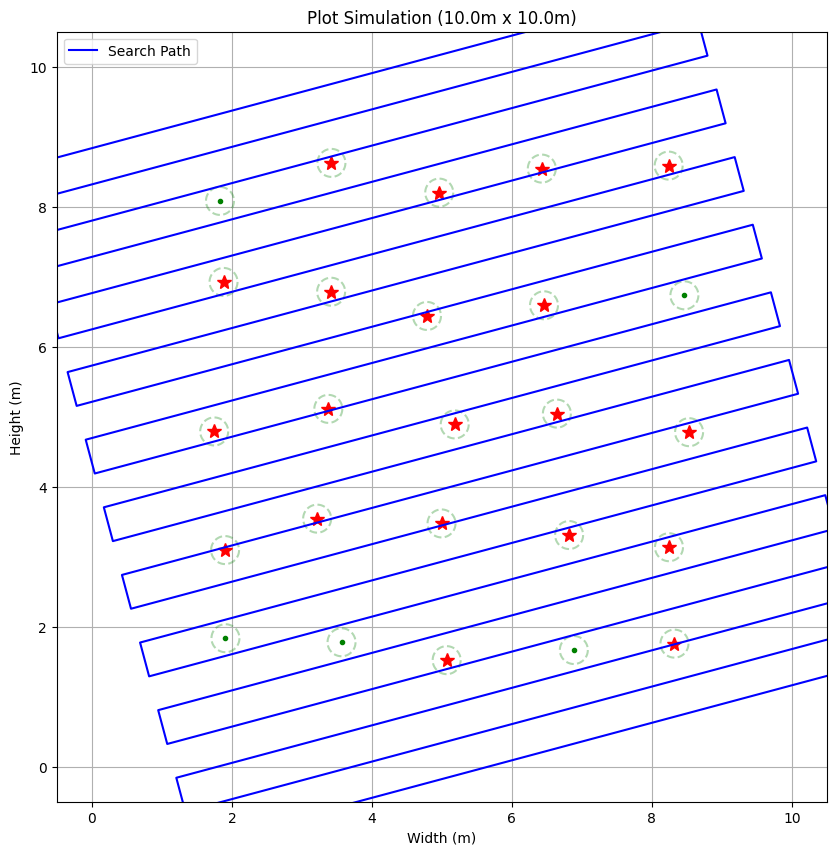


=== Testing gradient distribution ===

Parallel pattern summary:
        detection_rate           path_length      efficiency          
                  mean       std        mean  std       mean       std
spacing                                                               
0.5           0.960000  0.043461  410.249844  0.0   0.070201  0.003178
1.0           0.653333  0.086923  210.498756  0.0   0.093112  0.012388
1.5           0.460000  0.098319  130.671245  0.0   0.105609  0.022572
2.0           0.386667  0.090062  110.990195  0.0   0.104514  0.024343
2.5           0.326667  0.043461   91.231056  0.0   0.107420  0.014292

Zigzag pattern summary:
              detection_rate           path_length      efficiency          
                        mean       std        mean  std       mean       std
spacing angle                                                               
0.5     0.0         0.846667  0.101653       220.0  0.0   0.115455  0.013862
        15.0        0.700000  0.1

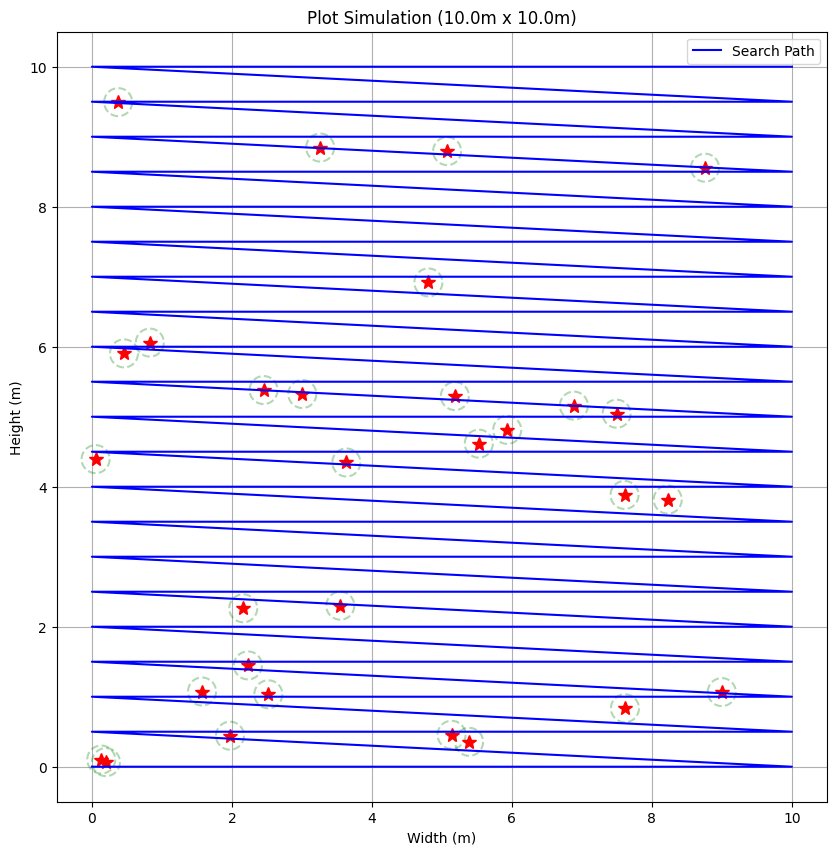


Best Zigzag Pattern (spacing=0.5m, angle=0.0°):
Detection Rate: 90.00%
Path Length: 220.0m


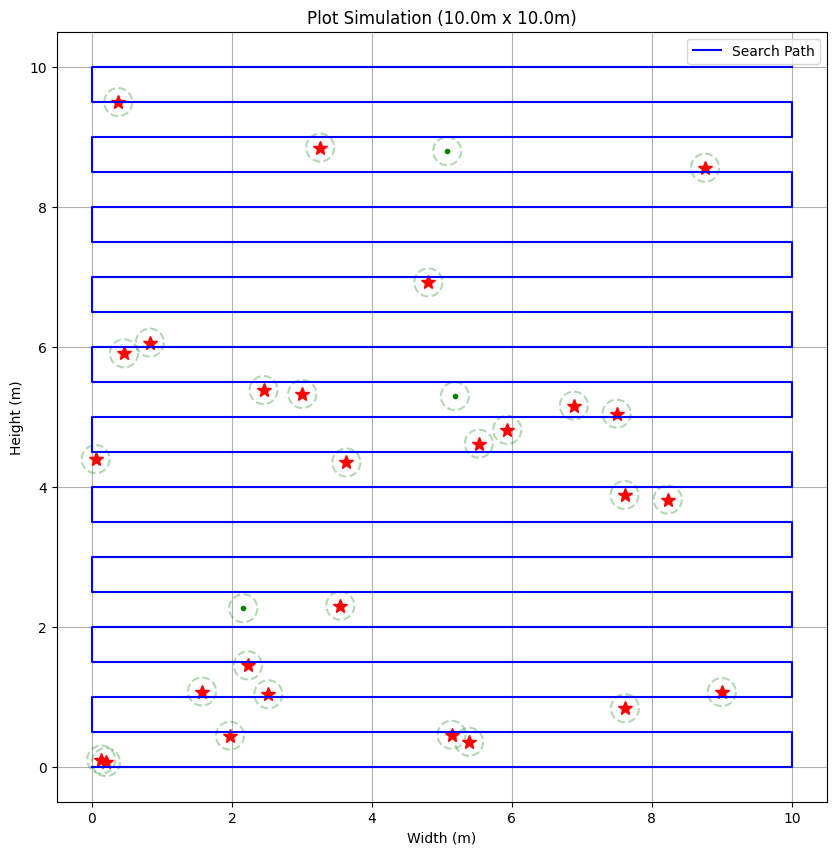

In [3]:
# Define distributions to test
distributions = {
    'random': {
        'distribution': 'random',
        'detection_params': {'fixed': 0.2}
    },
    'clustered': {
        'distribution': 'clustered',
        'distribution_params': {'n_clusters': 3, 'cluster_std': 1.0},
        'detection_params': {'fixed': 0.2}
    },
    'regular': {
        'distribution': 'regular',
        'distribution_params': {'jitter': 0.3},
        'detection_params': {'fixed': 0.2}
    },
    'gradient': {
        'distribution': 'gradient',
        'distribution_params': {'direction': 'x', 'steepness': 2.0},
        'detection_params': {'fixed': 0.2}
    }
}

# Test each distribution
for dist_name, dist_params in distributions.items():
    print(f"\n=== Testing {dist_name} distribution ===")
    
    # Create optimizer
    optimizer = SearchOptimization({
        'n_plants': 30,
        **dist_params
    })
    
    # Run parameter sweep
    optimizer.run_parameter_sweep(
        n_trials=5,
        spacings=[0.5, 1.0, 1.5, 2.0, 2.5],
        angles=[0, 15, 30, 45, 60]
    )
    
    # Analyze and display results
    results = optimizer.analyze_results()
    
    print("\nParallel pattern summary:")
    print(results['parallel_summary'])
    print("\nZigzag pattern summary:")
    print(results['zigzag_summary'])
    
    # Plot best patterns
    optimizer.plot_best_patterns()